<a href="https://colab.research.google.com/github/ksy-20908/godoheon/blob/main/%EC%B6%A9%EB%82%A8%EB%8C%80_%EB%B0%B0%EC%9E%AC%EB%8C%80_AI_%EB%94%A5%EB%9F%AC%EB%8B%9D_3%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 도구 준비
import os
import shutil
import random
import re                                # 문자열 처리
import string                            # 문자열 처리

import tensorflow as tf                  # 텐서플로우
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as fm
import numpy as np

print(f'Tensorflow 버전을 확인합니다: {tf.__version__}')

Tensorflow 버전을 확인합니다: 2.2.0


In [ ]:
# 시각화 도구 (matplotlib) 한글 폰트
fonts = fm.findSystemFonts()
nanum_path = None
for font in fonts:
    if font.endswith('NanumGothic.ttf'):
        nanum_path = font
        break
if nanum_path == None:
    print(f'나눔 폰트를 설치해야 합니다!')
    print(f'!apt install -qq -y fonts-nanum*')
else:
    print(f'나눔 폰트 경로: {nanum_path}')
    nanum_prop = fm.FontProperties(fname=nanum_path)

나눔 폰트 경로: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


In [ ]:
!apt install -qq -y fonts-nanum*

The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 35 not upgraded.
Need to get 37.0 MB of archives.
After this operation, 145 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected packa

In [ ]:
# ACL 2011 IMDB 데이터셋: 영화 리뷰 데이터셋 (ACL 2011 IMDB 논문에 사용된  데이터셋) 학습 데이터 다운로드
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 9s 0us/step


In [ ]:
# 데이터 확인
print(f'데이터 압축 디렉터리 내부: {os.listdir(dataset_dir)}')

# 학습 데이터 구조 확인
train_dir = os.path.join(dataset_dir, 'train')
print(f'학습 데이터 디렉터리 내부: {os.listdir(train_dir)}')

데이터 압축 디렉터리 내부: ['imdb.vocab', 'imdbEr.txt', 'test', 'README', 'train']
학습 데이터 디렉터리 내부: ['urls_unsup.txt', 'unsupBow.feat', 'unsup', 'urls_neg.txt', 'pos', 'labeledBow.feat', 'neg', 'urls_pos.txt']


In [ ]:
# 긍정 / 부정 데이터 파일 경로 확인 무작위로 10개씩 생성됨
pos_train_dir = os.path.join(train_dir, 'pos')
pos_train_files = os.listdir(pos_train_dir)
neg_train_dir = os.path.join(train_dir, 'neg')
neg_train_files = os.listdir(neg_train_dir)
print('긍정 파일: ', end='')
for _ in range(0, 10):
    print(random.choice(pos_train_files), end=' ')
print()
print('부정 파일: ', end='')
for _ in range(0, 10):
    print(random.choice(neg_train_files), end=' ')
print()
# 앞숫자는 평점 번호 _ 숫자는 평점

긍정 파일: 8679_8.txt 10996_8.txt 3604_10.txt 6160_10.txt 10014_8.txt 8508_7.txt 1801_8.txt 3937_8.txt 3171_9.txt 10273_8.txt 
부정 파일: 2830_3.txt 465_1.txt 1128_1.txt 7311_2.txt 1745_2.txt 4742_1.txt 4841_2.txt 7014_3.txt 1001_4.txt 8586_3.txt 


In [ ]:
# 학습 데이터 내용 살펴보기 긍정 데이터를 가져오면 내용이 무엇인지 확인 가능
sample_file = os.path.join(train_dir, 'pos', '7243_10.txt')
with open(sample_file, 'r') as f:
    print(f.read())

A brilliant Russian émigré devises the Stanislavsky' system for winning at contract bridge - which makes him and his beautiful wife the GRAND SLAM Sweethearts of America.<br /><br />What could have been just another silly soap opera is elevated by fine production values & excellent acting to the status of a very enjoyable little comedy. A few unexpected touches are thrown in to keep the viewer's attention engaged - the way in which the principle cast is introduced as faces on a deck of cards; the introduction of a zany acrobat into the plot for no other reason than to enjoy a bit of lunacy; and the way in which a wide variety of different kinds of Americans are shown to be transfixed by listening to the broadcast of the concluding game.<br /><br />Paul Lukas & Loretta Young do very well as the Bridge Sweethearts - Lukas suave & sophisticated and Miss Young passionately loving and beautiful (even if the script keeps her puffing on a cigarette a bit too much). They are fun to watch, eve

In [ ]:
# 학습 데이터 정리 (unsup가 필요가 없으므로 삭제)
print('''학습을 위한 데이터는 이런 구조가 되어야 합니다.
train/
....pos/
........file1.txt
........file2.txt
....neg/
........file1.txt
........file2.txt''')
remove_dir = os.path.join(train_dir, 'unsup')
print(f'불필요한 데이터 파일을 정리합니다. {remove_dir}')
shutil.rmtree(remove_dir)


학습을 위한 데이터는 이런 구조가 되어야 합니다.
train/
....pos/
........file1.txt
........file2.txt
....neg/
........file1.txt
........file2.txt
불필요한 데이터 파일을 정리합니다. ./aclImdb/train/unsup


In [ ]:
import multiprocessing

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.ops import string_ops
from tensorflow.python.util.tf_export import keras_export


def index_directory(directory,
                    labels,
                    formats,
                    class_names=None,
                    shuffle=True,
                    seed=None,
                    follow_links=False):
    inferred_class_names = []
    for subdir in sorted(os.listdir(directory)):
        if os.path.isdir(os.path.join(directory, subdir)):
            inferred_class_names.append(subdir)
    if not class_names:
        class_names = inferred_class_names
    else:
        if set(class_names) != set(inferred_class_names):
            raise ValueError(
                    'The `class_names` passed did not match the '
                    'names of the subdirectories of the target directory. '
                    'Expected: %s, but received: %s' %
                    (inferred_class_names, class_names))
    class_indices = dict(zip(class_names, range(len(class_names))))

    pool = multiprocessing.pool.ThreadPool()
    results = []
    filenames = []
    for dirpath in (os.path.join(directory, subdir) for subdir in class_names):
        results.append(
            pool.apply_async(index_subdirectory,
                             (dirpath, class_indices, follow_links, formats)))
    labels_list = []
    for res in results:
        partial_filenames, partial_labels = res.get()
        labels_list.append(partial_labels)
        filenames += partial_filenames
    if labels != 'inferred':
        if len(labels) != len(filenames):
            raise ValueError('Expected the lengths of `labels` to match the number '
                             'of files in the target directory. len(labels) is %s '
                             'while we found %s files in %s.' % (
                                     len(labels), len(filenames), directory))
    else:
        i = 0
        labels = np.zeros((len(filenames),), dtype='int32')
        for partial_labels in labels_list:
            labels[i:i + len(partial_labels)] = partial_labels
            i += len(partial_labels)

    print('Found %d files belonging to %d classes.' %
          (len(filenames), len(class_names)))
    pool.close()
    pool.join()
    file_paths = [os.path.join(directory, fname) for fname in filenames]

    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(file_paths)
        rng = np.random.RandomState(seed)
        rng.shuffle(labels)
    return file_paths, labels, class_names


def iter_valid_files(directory, follow_links, formats):
    walk = os.walk(directory, followlinks=follow_links)
    for root, _, files in sorted(walk, key=lambda x: x[0]):
        for fname in sorted(files):
            if fname.lower().endswith(formats):
                yield root, fname
        

def index_subdirectory(directory, class_indices, follow_links, formats):
    dirname = os.path.basename(directory)
    valid_files = iter_valid_files(directory, follow_links, formats)
    labels = []
    filenames = []
    for root, fname in valid_files:
        labels.append(class_indices[dirname])
        absolute_path = os.path.join(root, fname)
        relative_path = os.path.join(
                dirname, os.path.relpath(absolute_path, directory))
        filenames.append(relative_path)
    return filenames, labels
        

def check_validation_split_arg(validation_split, subset, shuffle, seed):
    if validation_split and not 0 < validation_split < 1:
        raise ValueError(
                '`validation_split` must be between 0 and 1, received: %s' %
                (validation_split,))
    if (validation_split or subset) and not (validation_split and subset):
        raise ValueError(
                'If `subset` is set, `validation_split` must be set, and inversely.')
    if subset not in ('training', 'validation', None):
        raise ValueError('`subset` must be either "training" '
                         'or "validation", received: %s' % (subset,))
    if validation_split and shuffle and seed is None:
        raise ValueError(
                'If using `validation_split` and shuffling the data, you must provide '
                'a `seed` argument, to make sure that there is no overlap between the '
                'training and validation subset.')


def get_training_or_validation_split(samples, labels, validation_split, subset):
    if not validation_split:
        return samples, labels

    num_val_samples = int(validation_split * len(samples))
    if subset == 'training':
        print('Using %d files for training.' % (len(samples) - num_val_samples,))
        samples = samples[:-num_val_samples]
        labels = labels[:-num_val_samples]
    elif subset == 'validation':
        print('Using %d files for validation.' % (num_val_samples,))
        samples = samples[-num_val_samples:]
        labels = labels[-num_val_samples:]
    else:
        raise ValueError('`subset` must be either "training" '
                         'or "validation", received: %s' % (subset,))
    return samples, labels


def labels_to_dataset(labels, label_mode, num_classes):
    label_ds = dataset_ops.Dataset.from_tensor_slices(labels)
    if label_mode == 'binary':
        label_ds = label_ds.map(
                lambda x: array_ops.expand_dims(math_ops.cast(x, 'float32'), axis=-1))
    elif label_mode == 'categorical':
        label_ds = label_ds.map(lambda x: array_ops.one_hot(x, num_classes))
    return label_ds


def paths_and_labels_to_dataset(file_paths,
                                labels,
                                label_mode,
                                num_classes,
                                max_length):
    path_ds = dataset_ops.Dataset.from_tensor_slices(file_paths)
    string_ds = path_ds.map(
        lambda x: path_to_string_content(x, max_length))
    if label_mode:
        label_ds = labels_to_dataset(labels, label_mode, num_classes)
        string_ds = dataset_ops.Dataset.zip((string_ds, label_ds))
    return string_ds


def path_to_string_content(path, max_length):
    txt = io_ops.read_file(path)
    if max_length is not None:
        txt = string_ops.substr(txt, 0, max_length)
    return txt

# 이 함수로 directory에서 text_dataset을 불러옴
def text_dataset_from_directory(directory,
                                labels='inferred',
                                label_mode='int',
                                class_names=None,
                                batch_size=32,
                                max_length=None,
                                shuffle=True,
                                seed=None,
                                validation_split=None,
                                subset=None,
                                follow_links=False):
    if labels != 'inferred':
        if not isinstance(labels, (list, tuple)):
            raise ValueError(
                    '`labels` argument should be a list/tuple of integer labels, of '
                    'the same size as the number of text files in the target '
                    'directory. If you wish to infer the labels from the subdirectory '
                    'names in the target directory, pass `labels="inferred"`. '
                    'If you wish to get a dataset that only contains text samples '
                    '(no labels), pass `labels=None`.')
        if class_names:
            raise ValueError('You can only pass `class_names` if the labels are '
                             'inferred from the subdirectory names in the target '
                             'directory (`labels="inferred"`).')
    if label_mode not in {'int', 'categorical', 'binary', None}:
        raise ValueError(
                '`label_mode` argument must be one of "int", "categorical", "binary", '
                'or None. Received: %s' % (label_mode,))
    if seed is None:
        seed = np.random.randint(1e6)
    check_validation_split_arg(
        validation_split, subset, shuffle, seed)
    
    file_paths, labels, class_names = index_directory(
            directory,
            labels,
            formats=('.txt',),
            class_names=class_names,
            shuffle=shuffle,
            seed=seed,
            follow_links=follow_links)

    if label_mode == 'binary' and len(class_names) != 2:
        raise ValueError(
                'When passing `label_mode="binary", there must exactly 2 classes. '
                'Found the following classes: %s' % (class_names,))

    file_paths, labels = get_training_or_validation_split(
        file_paths, labels, validation_split, subset)

    dataset = paths_and_labels_to_dataset(
        file_paths=file_paths,
        labels=labels,
        label_mode=label_mode,
        num_classes=len(class_names),
        max_length=max_length)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    dataset.class_names = class_names
    return dataset

In [ ]:
# 학습 데이터 불러오기 (2.4.X에서는 text_dataset_from_directory 사용 가능(2.2.X는 사용 불가하므로 위에 코드 사용해야 됨))
batch_size = 32
validation_split = 0.2
seed = 20200721 # 원하는 숫자 넣어도 상관없음

print('학습 데이터 세트를 불러옵니다.')
raw_train_ds = text_dataset_from_directory(
        train_dir, 
        batch_size=batch_size, 
        validation_split=validation_split, 
        subset='training',  # training 학습용 데이터 세트
        seed=seed)

학습 데이터 세트를 불러옵니다.
Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
# 학습 데이터 확인
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])


print('레이블 번호 - 이름 확인!')
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])


print('검증 데이터 세트를 불러옵니다.')
raw_val_ds = text_dataset_from_directory(
        train_dir, 
        batch_size=batch_size, 
        validation_split=validation_split, 
        subset='validation', 
        seed=seed)

Review b"This film was a yawn from titles to credits, it's boring to the point of tedium and the acting is wooden and stilted! Admittedly this was director Richard Jobson directing debut, but who on earth green-lit a script as poorly developed as this one? Looks like another money down the drain government project (Scottish Screen are credited surprise, surprise). I nearly fell asleep three times and my review will unfortunately have to be more restrained than this one. Please, please mister Jobson what ever you've been doing prior to directing this sedative of a film, go back to it!"
Label 0
Review b'I have given this show (I have only watched seven episodes) four stars because most of her jokes/set-ups appear to fail. Some are not funny outright, but some are amusing -- in a 12 year old boy kind of way. She reminds me of that New York painter who throws paint upon a canvas, calls it art and sells it for a lot of money. Silverman throws out what she\'s got, including the kitchen sink,

In [ ]:
# 불필요한 데이터 제거 (안지우면 문제 생김)
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [ ]:
# Vectorization (단어 하나하나에 번호를 붙일거임)
max_features = 100000 # N개의 단어를 볼거임
sequence_length = 5000
# 문저열을 숫자로 바꿈 (백터화)
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_features,
        output_mode='int',
        output_sequence_length=sequence_length)

In [ ]:
# Vectorization 레이어 계산
print('테스트 데이터와 레이블을 분리합니다.')
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print('학습 완료 후 사용할 테스트 세트를 불러옵니다.')
test_dir = os.path.join(dataset_dir, 'test')
raw_test_ds = text_dataset_from_directory(
        test_dir, 
        batch_size=batch_size)

테스트 데이터와 레이블을 분리합니다.
학습 완료 후 사용할 테스트 세트를 불러옵니다.
Found 25000 files belonging to 2 classes.


In [ ]:
# 전처리된 데이터 확인
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

print('테스트 데이터를 확인합니다.')
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)                                    #  0번 리뷰
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(tf.expand_dims(first_review, -1), first_label))  # 50단어만 숫자로 바꿔서 볼거임

테스트 데이터를 확인합니다.
Review tf.Tensor(b"The film is worth watching only if you stop it after half an hour. It starts of with funny conversations in a bar and makes one expect a good, funny story is to come. Well, I can tell you it will not come. It will deteriorate in minutes into a movie that challenges your patience as well as your feelings of shame for the actors to an extend you will probably not be pleased to witness. <br /><br />In an interview I heard that the director wanted to express in this film the feeling of a loss of identity that, according to him, the majority of the people in this globalizing world experience. I was amazed to hear that. Am I living in the same world he lives in? OK a lot of people do walk around in the same clothes as mine and listen to the same music and all, but that doesn't make me feel like I am losing my identity. What does Khrzhanosvky think, that we are not more than the clothes we wear and the movies we watch? Am I shortsighted or is he?<br /><br />

In [ ]:
# 특징 벡터 생성을 위한 단어집 확인
print('각 특징 벡터의 원소 값을 확인할 수 있습니다.')
voc_size = len(vectorize_layer.get_vocabulary())
print(f'Vocabulary size: {voc_size}')
base = 0
cnt = 10
if voc_size - cnt < base:
    print(f'{voc_size-cnt} 보다는 작은 수를 입력해야 합니다.') 
else:
    for i in range(base, base+cnt):
        print(f'{i+2:4d} ---> {vectorize_layer.get_vocabulary()[i].decode("utf-8")}') # 0은 THE 가 아니니까 2를 더함
# 0 --> 빈 단어
# 1 --> 모르는 단어 (EX 한국어)
#

각 특징 벡터의 원소 값을 확인할 수 있습니다.
Vocabulary size: 99496
   2 ---> the
   3 ---> and
   4 ---> a
   5 ---> of
   6 ---> to
   7 ---> is
   8 ---> in
   9 ---> it
  10 ---> i
  11 ---> this


In [ ]:
# 데이터셋 벡터화
print('학습, 검증, 테스트 데이터를 모두 벡터화 합니다.')
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# prefetch 데이터 학습을 조금더 빨리 하게 해주는 코드
AUTOTUNE = tf.data.experimental.AUTOTUNE
print('데이터 입력부를 최적화합니다.')
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

학습, 검증, 테스트 데이터를 모두 벡터화 합니다.
데이터 입력부를 최적화합니다.


In [ ]:
# One-hot vector 하나만 1임 나머지 0 근데 너무 0이 많아서 공간 손실이 많이 남 
# Encoding 그래서 이걸 씀 근데 이것도 비슷한것 끼리 묶여있지 않음 
# Word2Vec를 가장 많이 씀 알아서 계산하게 함

In [ ]:
# 모델 정의 및 Word2Vec
embedding_dim = 4 # N개의 단어를 N차원으로 바꿈

print('모델을 정의합니다.')
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features+1, embedding_dim, mask_zero=True),
    tf.keras.layers.Dropout(0.2), # 0.2 이하는 지움
    tf.keras.layers.GlobalAveragePooling1D(), # 평균을 냄
    tf.keras.layers.Dropout(0.2),  #0.2 이하는 지움
    tf.keras.layers.Dense(1)]) # 4개를 1개로 합친다

model.summary()

# Binary는 이진분류 할 때 씀
print('모델을 준비합니다.')
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer='adam', 
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

모델을 정의합니다.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           400004    
_________________________________________________________________
dropout (Dropout)            (None, None, 4)           0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 4)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 400,009
Trainable params: 400,009
Non-trainable params: 0
_________________________________________________________________
모델을 준비합니다.


In [ ]:
# 학습 시작! (Over fitting! 떄문에 학습하다가 더이상 올라가지 않음)
epochs = 10
history = model.fit(
        train_ds,
        validation_data=val_ds, # 학습 검증
        epochs=epochs)

Epoch 1/10
625/625 [==============================] - 16s 26ms/step - loss: 0.5446 - binary_accuracy: 0.8270 - val_loss: 0.5134 - val_binary_accuracy: 0.8270
Epoch 2/10
625/625 [==============================] - 17s 27ms/step - loss: 0.4688 - binary_accuracy: 0.8522 - val_loss: 0.4516 - val_binary_accuracy: 0.8424
Epoch 3/10
625/625 [==============================] - 17s 27ms/step - loss: 0.4116 - binary_accuracy: 0.8722 - val_loss: 0.4061 - val_binary_accuracy: 0.8564
Epoch 4/10
625/625 [==============================] - 17s 27ms/step - loss: 0.3670 - binary_accuracy: 0.8837 - val_loss: 0.3726 - val_binary_accuracy: 0.8638
Epoch 5/10
625/625 [==============================] - 16s 26ms/step - loss: 0.3319 - binary_accuracy: 0.8962 - val_loss: 0.3472 - val_binary_accuracy: 0.8714
Epoch 6/10
625/625 [==============================] - 17s 28ms/step - loss: 0.3051 - binary_accuracy: 0.9047 - val_loss: 0.3276 - val_binary_accuracy: 0.8744
Epoch 7/10
625/625 [==============================] 

In [ ]:
# 모델 성능 테스트 시작!
print('모델 성능을 테스트합니다.')
loss, accuracy = model.evaluate(test_ds) # 테스트 셋

print("Loss: ", loss)
print("Accuracy: ", accuracy)

모델 성능을 테스트합니다.
782/782 [==============================] - 14s 17ms/step - loss: 0.2955 - binary_accuracy: 0.8822
Loss:  0.2954935133457184
Accuracy:  0.8822399973869324


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48143 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51613 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_

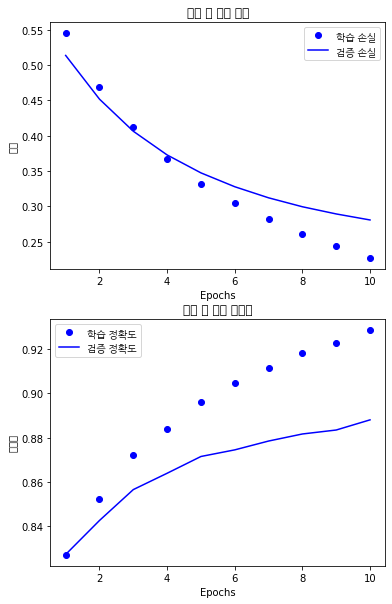

In [ ]:
# 시각화!
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig1 = plt.figure(figsize=(6, 10))
ax = fig1.add_subplot(2, 1, 1)
ax.plot(epochs, loss, 'bo', label='학습 손실')
ax.plot(epochs, val_loss, 'b', label='검증 손실')
ax.set_title('학습 및 검증 손실', fontsize=12)
ax.set_xlabel('Epochs', fontsize=10)
ax.set_ylabel('손실', fontsize=10)
ax.legend(prop=nanum_prop)

ax = fig1.add_subplot(2, 1, 2)
ax.plot(epochs, acc, 'bo', label='학습 정확도')
ax.plot(epochs, val_acc, 'b', label='검증 정확도')
ax.set_title('학습 및 검증 정확도', fontsize=12)
ax.set_xlabel('Epochs', fontsize=10)
ax.set_ylabel('정확도', fontsize=10)
ax.legend(prop=nanum_prop)

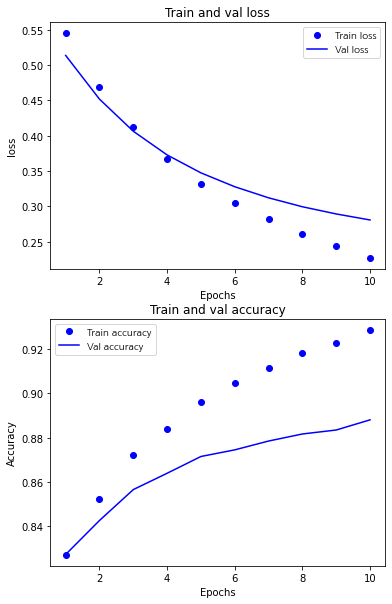

In [ ]:
# 한글폰트 안될 때
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig1 = plt.figure(figsize=(6, 10))
ax = fig1.add_subplot(2, 1, 1)
ax.plot(epochs, loss, 'bo', label='Train loss')
ax.plot(epochs, val_loss, 'b', label='Val loss')
#ax.set_ylim((0, 1))
ax.set_title('Train and val loss', fontsize=12)
ax.set_xlabel('Epochs', fontsize=10)
ax.set_ylabel('loss', fontsize=10)
ax.legend(prop=nanum_prop)

ax = fig1.add_subplot(2, 1, 2)
ax.plot(epochs, acc, 'bo', label='Train accuracy')
ax.plot(epochs, val_acc, 'b', label='Val accuracy')
#ax.set_ylim((0, 1))
ax.set_title('Train and val accuracy', fontsize=12)
ax.set_xlabel('Epochs', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(prop=nanum_prop)

In [ ]:
# 출력 모델
print('모델 출력')
export_model = tf.keras.Sequential([
    vectorize_layer, # 문자열을 숫자열로 바꾸어 줌
    model,
    tf.keras.layers.Activation('sigmoid') # 어떤수가 들어가도 0~1 사이로 고정
])

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

모델 출력
782/782 [==============================] - 13s 17ms/step - loss: 0.2955 - accuracy: 0.8822
0.8822399973869324


In [ ]:
# 임의의 데이터로 가지고 놀기! # 악플이나 선플 분류
user_str = input('테스트 입력: ').strip()
predicted = export_model.predict(tf.expand_dims(user_str, -1))[0][0]
print(f'예측 결과: {raw_train_ds.class_names[int(round(predicted))]} ({predicted:0.4f})')

테스트 입력: A brilliant Russian émigré devises the Stanislavsky' system for winning at contract bridge - which makes him and his beautiful wife the GRAND SLAM Sweethearts of America.<br /><br />What could have been just another silly soap opera is elevated by fine production values & excellent acting to the status of a very enjoyable little comedy. A few unexpected touches are thrown in to keep the viewer's attention engaged - the way in which the principle cast is introduced as faces on a deck of cards; the introduction of a zany acrobat into the plot for no other reason than to enjoy a bit of lunacy; and the way in which a wide variety of different kinds of Americans are shown to be transfixed by listening to the broadcast of the concluding game.<br /><br />Paul Lukas & Loretta Young do very well as the Bridge Sweethearts - Lukas suave & sophisticated and Miss Young passionately loving and beautiful (even if the script keeps her puffing on a cigarette a bit too much). They are fun to wa